In [36]:
import numpy as np
import matplotlib.pyplot as pl
import openpyxl
import dateutil
import datetime
import pickle
import pystan
import seaborn as sns
from hashlib import md5
import matplotlib
%matplotlib notebook

In [37]:
matplotlib.get_backend()
print(pystan.__version__)

2.9.0.0


## Análisis de los sondeos electorales 2016

Vamos a plantearnos como ejercicio analizar los sondeos electorales. Para ello cogemos como datos los sondeos recopilados en la página web de la Wikipedia para las elecciones de 2015 y para las de 2016. Consideramos sólo los partidos PP, PSOE, IU, Podemos y Ciudadanos. El resto de partidos se consideran metidos dentro de un mismo saco, que vienen siendo alrededor del 15% en cada sondeo.

Para modelar la evolución temporal de los sondeos para cada partido, usamos un modelado con variables latentes. La idea es que los resultados de los sondeos son sólo una estimación ruidosa y sesgada de la intención de voto real de los votantes. Por tanto, considamos que $\theta_i(t_j)$ es la subyacente intención de voto para el partido $i$ en el tiempo $t_j$. Esta variable se observa de forma ruidosa para cada empresa $k$ que realiza el sondeo, y además incluye un cierto sesgo. Por tanto, nuestro modelo de observación es:

$$
y_{ik}(t_j) \sim N(\theta_i(t_j) + b_{ik}, \sigma_{k}(t_j)^2)
$$

donde $b_{ik}$ es el bias que introduce la empresa de sondeos $k$ sobre el partido $i$ y $\sigma_{ik}^2$ es la varianza del sondeo realizado en el tiempo $t_j$ por la empresa $k$. Para los resultados de las elecciones, elegimos una varianza muy pequeña y no incluimos los sesgos, porque es el único momento en el que tenemos acceso directo a las intenciones subyacentes:

$$
y_{ik}(\mathrm{elecciones}) \sim N(\theta_i(t_j), \sigma_{k}(\mathrm{elecciones})^2).
$$

Es obvio que la suma de porcentajes de cada partido debe sumar 1 en cada sondeo, por lo cual debemos asegurarnos de que

$$
\sum_i \theta_i(t_j) = 1.
$$

Además, es lógico asumir que, dadas suficientes casas de sondeo, los biases sumen 0 para cada partido:

$$
\sum_k b_{ik} = 0.
$$

Por último, asumimos un proceso autoregresivo Markoviano para modelar la variación temporal de la intención de voto real para cada partido. Es decir, en cada sondeo, la intención de voto estará dada por una variable Gaussiana con media igual a la intención de voto anterior, y una varianza que debemos estimar para cada partido:

$$
\theta_i(t_j) \sim N(\theta_i(t_{j-1}), \sigma_i^2)
$$

Como es un parámetro de escala, definimos un prior poco informativo sobre $\sigma_i$:

$$
\sigma_i \sim IG(0.01,0.01).
$$

Por último, debemos definir un prior para $\theta_i(t_0)$, para el cual escogemos una distribución de Dirichlet con $\alpha=1$:

$$
\theta_i(t_0) \sim \mathrm{Dir}(\alpha).
$$

### Modelo Stan

In [ ]:
# %load model.stan
data {
  int<lower=0> NPartidos;
  int<lower=0> NSondeos;
  int<lower=0> NEmpresas;
  int<lower=0> NDates;
  real<lower=0> sondeos[NSondeos, NPartidos];
  int empresa[NSondeos];
  vector[NSondeos] sigmaSondeo;
  int date[NSondeos];
  vector<lower=0>[NPartidos] alpha;
}
parameters {
  real<lower=0> sigma[NPartidos];
#  real<lower=0> sigmaExtra;
  simplex[NPartidos] theta[NDates];
  real house_free[NEmpresas-1,NPartidos];
}

transformed parameters {
  real house[NEmpresas,NPartidos];
  
  for (i in 1:NPartidos) {
    for(k in 1:(NEmpresas-1)) {
      house[k,i] <- house_free[k,i];
    }
    house[NEmpresas,i] <- -sum(house_free[:,i]);
  }
}

model {

#  for (i in 1:NDates) {
#    theta[i] ~ dirichlet(alpha);
#  }

  for (i in 1:NPartidos) sigma[i] ~ inv_gamma(0.01,0.01);
#  sigmaExtra ~ inv_gamma(0.001, 0.001);

  theta[1] ~dirichlet(alpha);

  for (i in 2:NDates) {
    theta[i] ~ normal(theta[i-1], sigma);
  }

  for (i in 1:NPartidos) {
    for (j in 1:NEmpresas-1) {
      house_free[j,i] ~ normal(0, 0.05);
    }
  }

  for (i in 1:NSondeos) {
    for (j in 1:NPartidos) {
      if (empresa[i] == 11)        
        sondeos[i,j] ~ normal(theta[date[i],j], sigmaSondeo[i]);
      else
        #sondeos[i,j] ~ normal(theta[date[i],j] + house[empresa[i],j], sqrt(sigmaSondeo[i]*sigmaSondeo[i]+sigmaExtra*sigmaExtra));
        sondeos[i,j] ~ normal(theta[date[i],j] + house[empresa[i],j], sigmaSondeo[i]);
    }
  }

}

Definimos algunas funciones útiles para el parsing de la base de datos.

In [38]:
def stan_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm.sampling(**kwargs)

def toenglish(s):
    spanish = ['ene', 'abr', 'ago', 'dic', 'de mayo de']
    english = ['jan', 'apr', 'aug', 'dec', 'may']
    for (j, month) in enumerate(spanish):
        s = s.replace(month, english[j])
    return s

def getPercentage(s):
    if (s[0] not in ['0','1','2','3','4','5','6','7','8','9']):
        return 0
    else:
        if (s.find('%') != -1):
            return float(s.split('%')[0].replace(',','.')) / 100.0
        else:
            return float(s.split('\n')[0].replace(',','.')) / 100.0

def getSigma(s):
    left = s.find('(')
    right = s.find(')')    
    if (s[left+1:right] in ['?', '-']):
        return 0.03
    else:
        return 1.0 / np.sqrt(float(s[left+1:right]))

def weeksDifference(d1, d2):
    monday1 = (d1 - datetime.timedelta(days=d1.weekday()))
    monday2 = (d2 - datetime.timedelta(days=d2.weekday()))

    return int((monday2 - monday1).days / 7)

Leemos el fichero de datos obtenido de la Wikipedia y hacemos el parsing. Escogemos sólo aquellos sondeos en los que hay información para todos los partidos. Podríamos también escoger aquellos parciales porque el modelado Bayesiano los podría aceptar.

In [47]:
wb = openpyxl.load_workbook("data/sondeos.xlsx")
ws = wb.active

empresas = ['GAD3', 'Encuestamos', 'GESOP', 'Metroscopia', 'Celeste-Tel',' Demoscopia Servicios', 'Simple Lógica', 'CIS', 'TNS Demoscopia', 'Invymark', 'Resultados de las elecciones']

empresaSondeoAll = []
sondeosAll = []
dateAll = []
sigmaAll = []

otrosPartidos = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'R']

nSondeos = 302
loopSondeos = 0
for i in range(120):#nSondeos):
    empresa = ws['A{0}'.format(i+2)].value
    for (loop, emp) in enumerate(empresas):
        if (empresa.find(emp) != -1):
            empresaSondeo = loop

    if (empresaSondeo == 10):
        sigma = 0.0001
    else:
        sigma = getSigma(empresa)

    PP = getPercentage(ws['C{0}'.format(i+2)].value)
    PSOE = getPercentage(ws['D{0}'.format(i+2)].value)
    IU = getPercentage(ws['E{0}'.format(i+2)].value)
    PODEMOS = getPercentage(ws['P{0}'.format(i+2)].value)
    CS = getPercentage(ws['Q{0}'.format(i+2)].value)

    total = PP + PSOE + IU + PODEMOS + CS
    otros = 1.0 - total    

    tmp = ws['B{0}'.format(i+2)].value
    if (isinstance(tmp, datetime.date)):
        date = tmp
    else:
        date = dateutil.parser.parse(toenglish(ws['B{0}'.format(i+2)].value.split('-')[-1].lower()))    

    tmp = date.year + (date.month-1.0) / 12.0

    sondeo = [PP, PSOE, IU+PODEMOS, CS, otros]
    
    if (0 not in sondeo):
        
        loopSondeos += 1

        sondeosAll.append(sondeo)
        sigmaAll.append(sigma)
    
        dateAll.append(date)
        empresaSondeoAll.append(empresaSondeo+1)

        print ("{0} - {1} {8} - s={9:4.2f} : PP={2:4.2f} - PSOE={3:4.2f} - IU={4:4.2f} - PODEMOS={5:4.2f} - CS={6:4.2f} - Resto={7:4.2f}".format(i, 
            empresas[empresaSondeo], PP*100, PSOE*100, IU*100, PODEMOS*100, CS*100, otros*100, date, sigma*100))

sondeosAll = np.array(sondeosAll)

nSondeos, nPartidos = sondeosAll.shape
nEmpresas = len(empresas)

print ("Número de sondeos incluidos : {0} de {1} posibles".format(loopSondeos,120))

# Compute week of every poll
weekAll = []
for i in range(nSondeos):
    weekAll.append(weeksDifference(dateAll[nSondeos-1], dateAll[i]) + 1)

nDates = max(weekAll)

# Reverse all lists
sondeosAll = sondeosAll[::-1]
empresaSondeoAll.reverse()
weekAll.reverse()
sigmaAll.reverse()

dictionary = {'NPartidos': nPartidos, 'NSondeos': nSondeos, 'NEmpresas': nEmpresas-1, 'NDates': nDates, 'empresa': empresaSondeoAll, 'sondeos': sondeosAll, 
'date': weekAll, 'sigmaSondeo': sigmaAll, 'alpha': np.ones(nPartidos)*1.0}

0 - GAD3 2016-04-29 00:00:00 - s=3.54 : PP=29.30 - PSOE=22.60 - IU=5.30 - PODEMOS=17.00 - CS=13.90 - Resto=11.90
1 - Metroscopia 2016-04-28 00:00:00 - s=2.89 : PP=29.00 - PSOE=20.30 - IU=6.60 - PODEMOS=18.10 - CS=16.00 - Resto=10.00
2 - Invymark 2016-04-29 00:00:00 - s=2.89 : PP=28.70 - PSOE=19.40 - IU=4.80 - PODEMOS=20.70 - CS=15.40 - Resto=11.00
3 - CIS 2016-04-10 00:00:00 - s=2.00 : PP=27.40 - PSOE=21.60 - IU=5.40 - PODEMOS=17.70 - CS=15.60 - Resto=12.30
4 - Invymark 2016-04-15 00:00:00 - s=3.00 : PP=28.60 - PSOE=20.40 - IU=5.40 - PODEMOS=19.20 - CS=15.80 - Resto=10.60
5 - Invymark 2016-04-14 00:00:00 - s=3.24 : PP=30.70 - PSOE=21.20 - IU=4.90 - PODEMOS=21.90 - CS=14.50 - Resto=6.80
6 - TNS Demoscopia 2016-04-14 00:00:00 - s=3.16 : PP=29.40 - PSOE=22.30 - IU=6.00 - PODEMOS=17.50 - CS=15.80 - Resto=9.00
7 - CIS 2016-01-11 00:00:00 - s=2.00 : PP=28.80 - PSOE=20.50 - IU=3.70 - PODEMOS=13.20 - CS=13.30 - Resto=20.50
8 - GAD3 2016-01-21 00:00:00 - s=3.53 : PP=30.10 - PSOE=21.30 - IU=2.90

Leemos el modelo que hemos definido y hacemos el sampling.

In [48]:
f = open('model.stan', 'r')
model = f.read()
f.close()

In [49]:
out = stan_cache(model, model_name='elecciones', data=dictionary, chains=1)

Using cached StanModel


### Resultados
Extraemos algunas de las cantidades interesantes para hacer algunas representaciones.

In [50]:
thetaChain = out.extract('theta')['theta']
theta = np.percentile(thetaChain, [50.0, 50.0-68/2.0, 50.0+68/2], axis=0)
houseChain = out.extract('house')['house']
house = np.percentile(houseChain, [50.0, 50.0-68/2.0, 50.0+68/2], axis=0)
sigmaChain = out.extract('sigma')['sigma']
sigma = np.percentile(sigmaChain, [50.0, 50.0-68/2.0, 50.0+68/2], axis=0)

### Sondeos y variación subyacente
En esta representación vemos la variación de las estimaciones de voto en puntos para cada una de las encuestas que hemos considerado y la estimación subyacente que hemos inferido. Como se ve, la varianza de la estimación subyacente cambia con el tiempo, siendo muy pequeña en la fecha de las elecciones, marcada con una línea vertical.

<IPython.core.display.Javascript object>


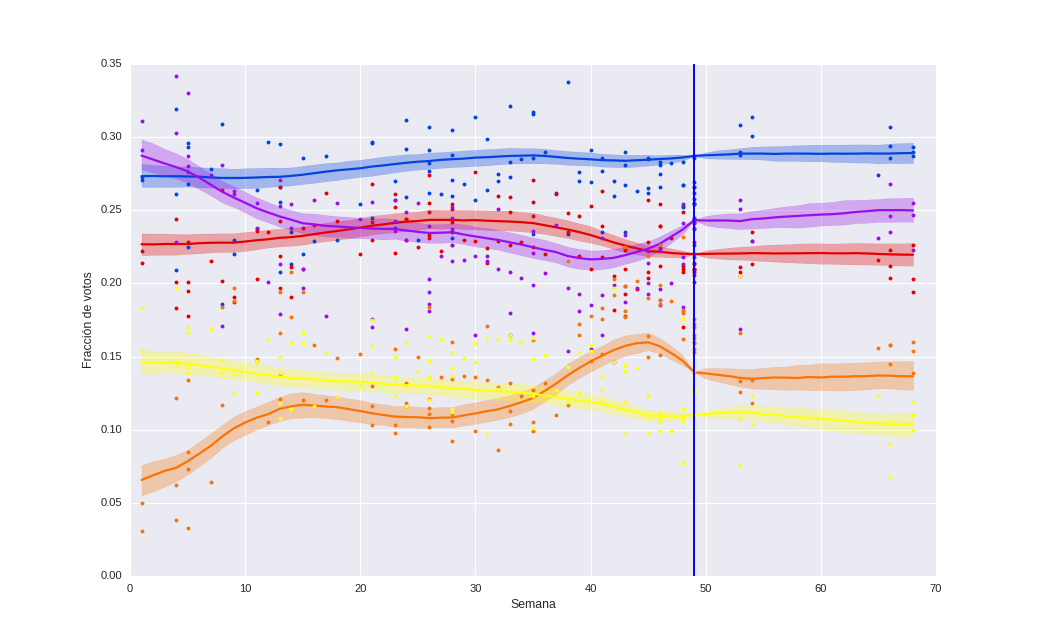

In [59]:
colors = ["blue", "red", "violet", "orange", "yellow"]
labelsPartidos = ['PP', 'PSOE', 'PODEMOS+IU', 'Cs', 'Otros']
labelsEmpresas = ['GAD3', 'Encuest', 'GESOP', 'Metroscopia', 'Celeste',' Demosc. S.', 'S. Lógica', 'CIS', 'TNS Demos.', 
                  'Invymark']
f, ax = pl.subplots(figsize=(13,8))
for i in range(5):
    ax.plot(weekAll, sondeosAll[:,i], '.', color=sns.xkcd_rgb[colors[i]], linewidth=2)
    ax.plot(np.arange(max(weekAll))+1, theta[0,:,i], color=sns.xkcd_rgb[colors[i]], linewidth=2)
    ax.fill_between(np.arange(max(weekAll))+1, theta[1,:,i], theta[2,:,i], color=sns.xkcd_rgb[colors[i]], alpha=0.3)
ax.set_xlabel('Semana')
ax.set_ylabel('Fracción de votos')
ax.axvline(49)

### Estimación de voto actual
A continuación pongo la estimación de voto actual y sus intervalos de confianza.

<IPython.core.display.Javascript object>


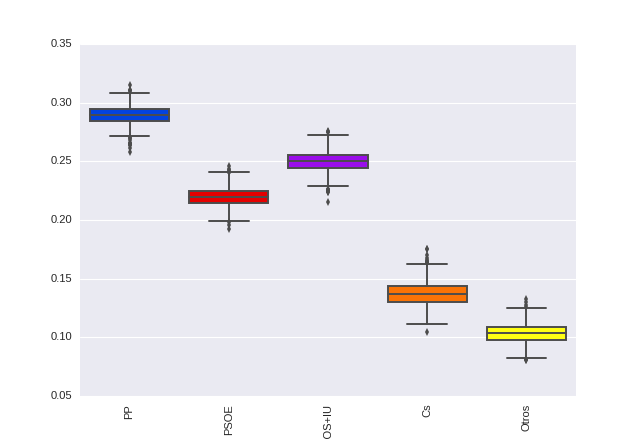

In [61]:
f, ax = pl.subplots()
sns.boxplot(data=thetaChain[:,-1,:], ax=ax)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(labelsPartidos, rotation=90)
boxes = ax.artists
for (i, box) in enumerate(boxes):
    box.set_facecolor(sns.xkcd_rgb[colors[i]])

A continuación represento la evolución temporal del voto por cada partido político, incluyendo las incertidumbres estimadas para cada sondeo.

<IPython.core.display.Javascript object>


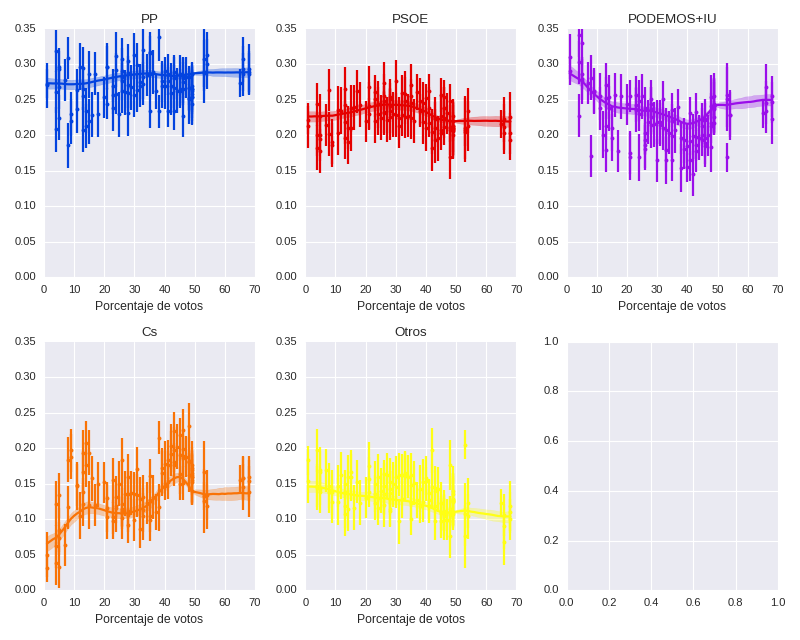

In [52]:
labelsPartidos = ['PP', 'PSOE', 'PODEMOS+IU', 'Cs', 'Otros']
f, ax = pl.subplots(nrows=2, ncols=3, figsize=(10,8))
ax = ax.flatten()
for i in range(5):
    ax[i].plot(weekAll, sondeosAll[:,i], '.', color=sns.xkcd_rgb[colors[i]], linewidth=2)
    ax[i].set_ylim([0,0.35])
    ax[i].errorbar(weekAll, sondeosAll[:,i], fmt='none', yerr=sigmaAll, color=sns.xkcd_rgb[colors[i]], linewidth=2, ecolor=sns.xkcd_rgb[colors[i]])
    ax[i].plot(np.arange(max(weekAll))+1, theta[0,:,i], color=sns.xkcd_rgb[colors[i]], linewidth=2)
    ax[i].fill_between(np.arange(max(weekAll))+1, theta[1,:,i], theta[2,:,i], color=sns.xkcd_rgb[colors[i]], alpha=0.3)
    ax[i].set_xlabel('Semana')
    ax[i].set_xlabel('Porcentaje de votos')
    ax[i].set_title(labelsPartidos[i])
pl.tight_layout()

### Sesgos por casa encuestadora
Represento a continuación las estimaciones de sesgo para cada una de las empresas encuestadoras, lo que muestra algún efecto curioso en Demoscopia Servicios que sería interesante analizar y entender por qué pasa. Nótese que un sesgo positivo implica que esa empresa subestima los votos y hace falta corregirlo por esa cantidad para obtener las observaciones.

<IPython.core.display.Javascript object>


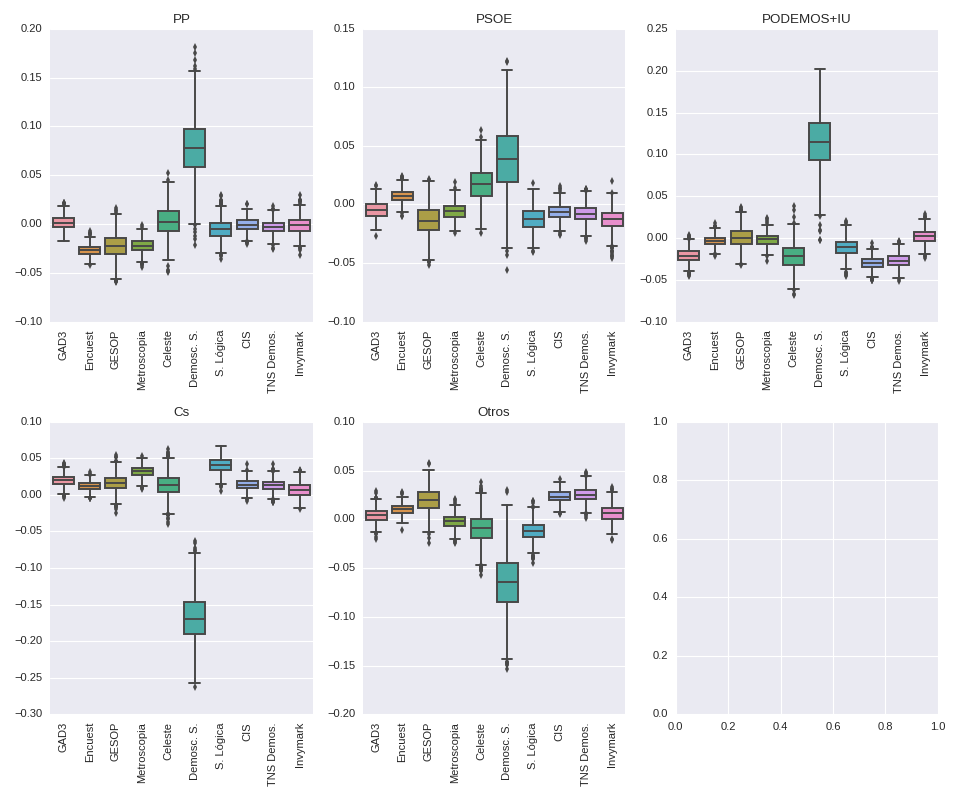

In [53]:
f, ax = pl.subplots(ncols=3, nrows=2, figsize=(12,10))
ax = ax.flatten()
for i in range(5):
    sns.boxplot(data=houseChain[:,:,i], ax=ax[i])
    ax[i].set_xticks(np.arange(10))
    ax[i].set_xticklabels(labelsEmpresas, rotation=90)
    ax[i].set_title(labelsPartidos[i])
pl.tight_layout()

### Variabilidad
Por último, aquí muestro la variabilidad intrínseca de la estimación subyacente de voto para cada partido. Es lógico que Podemos y Cs tengan una variabilidad mayor por su largo crecimiento en el último año.

<IPython.core.display.Javascript object>


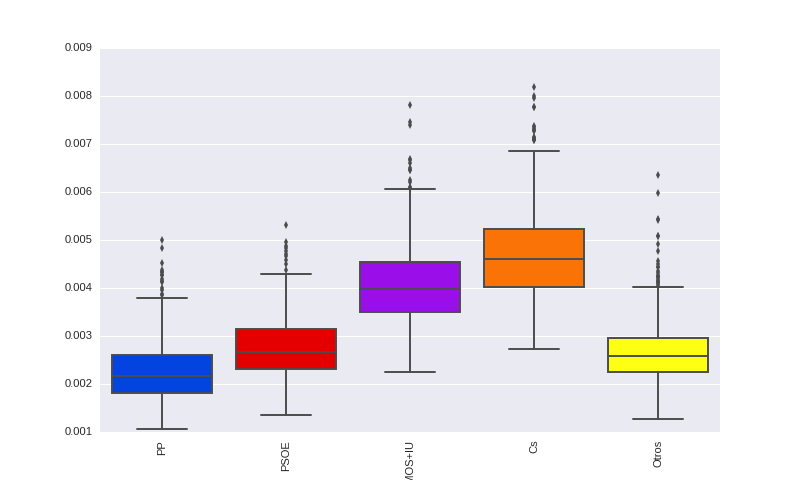

In [63]:
f, ax = pl.subplots(figsize=(10,6))
sns.boxplot(data=sigmaChain, ax=ax)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(labelsPartidos, rotation=90)
boxes = ax.artists
for (i, box) in enumerate(boxes):
    box.set_facecolor(sns.xkcd_rgb[colors[i]])

### Incluyendo correlación